In [2]:
!nvidia-smi

Tue May  7 17:27:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                   On |
| N/A   25C    P0    45W / 400W |     24MiB / 40536MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                   On |
| N/A   

In [2]:
import torch
torch.cuda.device_count()

1

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-40GB MIG 1g.5gb'

In [5]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
from torch import nn

import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torch.nn import Parameter

import matplotlib.pyplot as plt
import math

import numpy as np
import pandas as pd

from PIL import Image
import pathlib
from pathlib import Path

import os
import zipfile

from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
!unzip cropped_images.zip

Archive:  cropped_images.zip
warning [cropped_images.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [cropped_images.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace cropped_images/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [31]:
folder_path = 'cropped_images/'

# List all files in the folder
files = os.listdir(folder_path)


# Print the number of images
num_images = len(files)
print("Number of images in", folder_path, ":", num_images)

Number of images in cropped_images/ : 202402


In [32]:
identities = {}
with open('./identity_CelebA.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 10177 identities.
There are 202599 images.


In [33]:

import os
from shutil import copyfile


#source_root = 'img_align_celeba/'
source_root = 'cropped_images/'
target_root = 'celeba_identity_dataset/'
file_list = os.listdir(source_root)

for file in tqdm(file_list):
    identity = identities[file]
    source = os.path.join(source_root, file)
    target = os.path.join(target_root, str(identity), file)
    if not os.path.exists(os.path.join(target_root, str(identity))):
        os.makedirs(os.path.join(target_root, str(identity)))
    copyfile(source, target)

  0%|          | 0/202402 [00:00<?, ?it/s]

In [6]:
folder_path = 'celeba_identity_dataset/'

# List all items (folders) in the folder
folders = os.listdir(folder_path)

# Print the number of folders
num_folders = len(folders)
print("Number of folders in", folder_path, ":", num_folders)

Number of folders in celeba_identity_dataset/ : 10243


In [35]:
folder_root = './celeba_identity_dataset/'
folder_list = os.listdir(folder_root)

threshold = 2
identity_cnt = 0

train_images = 0
test_images = 0
train_ratio = 0.9

for folder in tqdm(folder_list):
    file_list = os.path.join(folder_root, folder)
    file_list = os.listdir(file_list)
    if len(file_list) >= threshold:
        identity_cnt += 1
        num_train = int(train_ratio * len(file_list))
        for file in file_list[:num_train]:
            train_images += 1
            source = os.path.join(folder_root, folder, file)
            target = os.path.join(folder_root, 'train', folder, file)
            if not os.path.exists(os.path.join(folder_root, 'train', folder)):
                os.makedirs(os.path.join(folder_root, 'train', folder))
            os.rename(source, target)
        for file in file_list[num_train:]:
            test_images += 1
            source = os.path.join(folder_root, folder, file)
            target = os.path.join(folder_root, 'test', folder, file)
            if not os.path.exists(os.path.join(folder_root, 'test', folder)):
                os.makedirs(os.path.join(folder_root, 'test', folder))
            os.rename(source, target)

print(f'There are {identity_cnt} identities that have more than {threshold} images.')
print(f'There are {train_images} train images.')
print(f'There are {test_images} test images.')

  0%|          | 0/10177 [00:00<?, ?it/s]

There are 10133 identities that have more than 2 images.
There are 178754 train images.
There are 23604 test images.


In [2]:
data_path = Path("celeba_identity_dataset/")

#image_path = data_path / "train"

#train_dir = data_path / "train" / "train"
#test_dir = data_path / "test" / "test"

image_path = data_path
train_dir = data_path / "train"

train_dir

NameError: name 'Path' is not defined

In [1]:
from PIL import Image
import random
#random.seed(42)

image_path_list = list(train_dir.glob("*/*.jpg"))

print(len(image_path_list))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

#random_image_path,image_class ,img.height,img.width
img

NameError: name 'train_dir' is not defined

In [9]:
import os
def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images")

walk_through_dir("celeba_identity_dataset/train")

there are 10133 directories and 0 images
there are 0 directories and 5 images
there are 0 directories and 1 images
there are 0 directories and 18 images
there are 0 directories and 21 images
there are 0 directories and 18 images
there are 0 directories and 9 images
there are 0 directories and 19 images
there are 0 directories and 17 images
there are 0 directories and 1 images
there are 0 directories and 18 images
there are 0 directories and 17 images
there are 0 directories and 18 images
there are 0 directories and 9 images
there are 0 directories and 27 images
there are 0 directories and 3 images
there are 0 directories and 27 images
there are 0 directories and 12 images
there are 0 directories and 22 images
there are 0 directories and 20 images
there are 0 directories and 11 images
there are 0 directories and 14 images
there are 0 directories and 27 images
there are 0 directories and 5 images
there are 0 directories and 27 images
there are 0 directories and 26 images
there are 0 dire

In [26]:
for i in range(1, 64 + 1):
    folder_path = f"test{i}"
    os.makedirs(folder_path, exist_ok=True)

In [30]:
import cv2
print(cv2.__version__)
import os
import matplotlib.pyplot as plt
from IPython.display import display, Image

root_dir = "test"

for identity_folder in os.listdir(root_dir):
    item_path = os.path.join(root_dir, identity_folder)
    for img_file in os.listdir(item_path):
        img_path = os.path.join(item_path, img_file)
        if img_file.endswith(".jpg"):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            box_width = img.shape[1] // 8
            box_height = img.shape[0] // 8
            
            result_images = []
            
            for i in range(8):
                for j in range(8):
                    x1 = j * box_width
                    y1 = i * box_height
                    x2 = (j + 1) * box_width
                    y2 = (i + 1) * box_height
            
                    box_img = img.copy()
                    box_img[y1:y2, x1:x2] = 0
            
                    result_images.append(box_img)
            #print(len(result_images))

            for i, box_img in enumerate(result_images):
                output_path = os.path.join(f"test{i+1}",identity_folder)
                os.makedirs(output_path, exist_ok=True)
                output_path = os.path.join(output_path, img_file)
                #print(output_path)
                cv2.imwrite(output_path, box_img)

            #display(Image(filename=img_path))
            #print(f"Identity Folder: {identity_folder}, Image: {img_file}")
            #print(img_path)


4.9.0


In [8]:
test_dir = data_path / "test"
test_dir

PosixPath('celeba_identity_dataset/test')

In [9]:
walk_through_dir("celeba_identity_dataset/test")

NameError: name 'walk_through_dir' is not defined

In [9]:
from PIL import Image
import random
#random.seed(42)

image_path_list = list(test_dir.glob("*/*.jpg"))

print(len(image_path_list))

23604


In [10]:
transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=train_dir,transform=transform,target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,transform=transform,target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 178754
     Root location: celeba_identity_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 23604
     Root location: celeba_identity_dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ))

In [11]:
image, label = train_data[5]
image, label,

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1804, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1843, 0.0000, 0.0000],
          [0.3961, 0.3961, 0.3961,  ..., 0.1882, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.9333,  ..., 0.6902, 0.6902, 0.6863],
          [0.0000, 0.0000, 0.9216,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.9098,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.1098, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1137, 0.0000, 0.0000],
          [0.2863, 0.2863, 0.2863,  ..., 0.1176, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.1255,  ..., 0.7098, 0.7098, 0.7059],
          [0.0000, 0.0000, 0.0902,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0667,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0627, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0706, 0.0000, 0.0000],
          [0.2039, 0.2039, 0.2078,  ...,

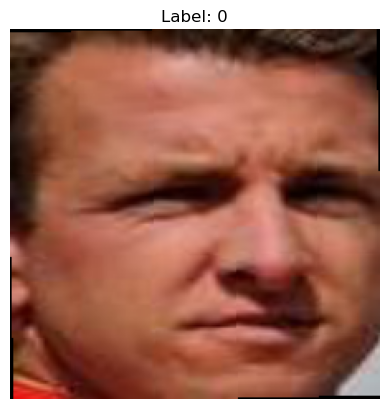

In [12]:
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title(f'Label: {label}')
plt.axis('off')  # Turn off axis labels
plt.show()

In [13]:

train_Dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_Dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

len(test_Dataloader),len(train_Dataloader)

(738, 5587)